In [5]:
# Learning Practice 7 for the University of Tulsa's QM-7063 Data Mining Course
# Classification and Regression Trees
# # Professor: Dr. Abdulrashid, Spring 2023
# Noah L. Schrick - 1492657

%matplotlib inline

from pathlib import Path
import matplotlib.pylab as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn import tree
import scikitplot as skplt
from dmba import regressionSummary, classificationSummary
from dmba import plotDecisionTree
from sklearn.model_selection import GridSearchCV


# Problem 9.1

Competitive Auctions on eBay.com. 

The file eBayAuctions.csv contains information on 1972 auctions that transacted on eBay.com during May–June 2004. The goal is to use these data to build a model that will classify auctions as competitive or non-competitive. A competitive auction is defined as an auction with at least two bids placed on the item auctioned. The data include variables that describe the item (auction category), the seller (his/her eBay rating), and the auction terms that the seller selected (auction duration, opening price, currency, day-of-week of auction close). In addition, we have the price at which the auction closed. The task is to predict whether or not the auction will be competitive. 

Data Preprocessing. 
Convert variable Duration into a categorical variable. Split the data into training (60%) and validation (40%) datasets. 

a. Fit a classification tree using all predictors. To avoid overfitting, set the minimum number of records in a terminal node to 50 and the maximum tree depth to 7. Write down the results in terms of rules. (Note: If you had to slightly reduce the number of predictors due to software limitations, or for clarity of presentation, which would be a good variable to choose?)
b. Is this model practical for predicting the outcome of a new auction? 
c. Describe the interesting and uninteresting information that these rules provide.
d. Fit another classification tree (using a tree with a minimum number of records per terminal node = 50 and maximum depth = 7), this time only with predictors that can be used for predicting the outcome of a new auction. Describe the resulting tree in terms of rules. Make sure to report the smallest set of rules required for classification.
e. Plot the resulting tree on a scatter plot: Use the two axes for the two best (quantitative) predictors. Each auction will appear as a point, with coordinates corresponding to its values on those two predictors. Use different colors or symbols to separate competitive and noncompetitive auctions. Draw lines (you can sketch these by hand or use Python) at the values that create splits. Does this splitting seem
reasonable with respect to the meaning of the two predictors? Does it seem to do a good job of separating the two classes?
f. Examine the lift chart and the confusion matrix for the tree. What can you say about the predictive performance of this model?
g. Based on this last tree, what can you conclude from these data about the chances of an auction obtaining at least two bids and its  relationship to the auction settings set by the seller (duration, opening price, ending day, currency)? What would you recommend for a seller as the strategy that will most likely lead to a competitive auction?

In [28]:
# Data pre-processing
auction_df = pd.read_csv('eBayAuctions.csv')

# Convert cols to categorical
auction_df['Duration'] = auction_df['Duration'].astype('category')
auction_df = pd.get_dummies(auction_df, prefix_sep='_', drop_first=True)

# Spec outcome
X = auction_df.drop(columns=['Competitive?'])
y = auction_df['Competitive?']
# 60/40 split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [20]:
# a
fullClassTree = DecisionTreeClassifier(random_state=1, min_samples_leaf=50, max_depth=7)
fullClassTree.fit(train_X, train_y)
tree_rules = export_text(fullClassTree, feature_names=list(train_X.columns))
print(tree_rules)


|--- OpenPrice <= 3.62
|   |--- ClosePrice <= 3.64
|   |   |--- OpenPrice <= 1.03
|   |   |   |--- class: 1
|   |   |--- OpenPrice >  1.03
|   |   |   |--- OpenPrice <= 2.45
|   |   |   |   |--- class: 0
|   |   |   |--- OpenPrice >  2.45
|   |   |   |   |--- class: 0
|   |--- ClosePrice >  3.64
|   |   |--- Duration_10 <= 0.50
|   |   |   |--- class: 1
|   |   |--- Duration_10 >  0.50
|   |   |   |--- class: 1
|--- OpenPrice >  3.62
|   |--- ClosePrice <= 10.00
|   |   |--- OpenPrice <= 4.97
|   |   |   |--- class: 0
|   |   |--- OpenPrice >  4.97
|   |   |   |--- ClosePrice <= 6.82
|   |   |   |   |--- class: 0
|   |   |   |--- ClosePrice >  6.82
|   |   |   |   |--- OpenPrice <= 7.99
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- OpenPrice >  7.99
|   |   |   |   |   |--- class: 0
|   |--- ClosePrice >  10.00
|   |   |--- OpenPrice <= 10.97
|   |   |   |--- OpenPrice <= 9.89
|   |   |   |   |--- class: 1
|   |   |   |--- OpenPrice >  9.89
|   |   |   |   |--- class: 1
|   | 

# If you had to slightly reduce the number of predictors due to software limitations, or for clarity of presentation, which would be a good variable to choose?
Category and Currency

In [24]:
# b
classificationSummary(valid_y, fullClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8162)

       Prediction
Actual   0   1
     0 305  48
     1  97 339


# b. Is this model practical for predicting the outcome of a new auction? 
This model works well for the dataset provided, but is not practical. The primary issue is that this model uses closePrice to predict the outcome, and closePrice is not something known in advance. In addition, for this set of data, the tree is quick to build and use, and has a 81.62% accuracy. However, many of the rules appear overfitted for the data provided.

# c. Describe the interesting and uninteresting information that these rules provide.
Of interest:
    The tree starts the split with OpenPrice, and is able to cleanly make a binary split.

Not of interest:
    If the OpenPrice > 3.62, the next split is based on ClosePrice. However, it "splits" into a "0" category, meaning ClosePrice does not apply much to the training data. From here, the rules appear overfitted, choosing various price points to split at.

In [56]:
# d
auction_df_2 = pd.read_csv('eBayAuctions.csv')

# Convert cols to categorical
auction_df_2['Duration'] = auction_df_2['Duration'].astype('category')
auction_df_2 = pd.get_dummies(auction_df_2, drop_first=True)

# Spec outcome
X_2 = auction_df_2.drop(list(auction_df_2.filter(regex = 'Category')), axis = 1)
X_2 = X_2.drop(list(X_2.filter(regex = 'currency')), axis = 1)
X_2 = X_2.drop(list(X_2.filter(regex = 'Competitive?')), axis = 1)
X_2 = X_2.drop(list(X_2.filter(regex = 'ClosePrice')), axis = 1)
y_2 = auction_df_2['Competitive?']

# 60/40 split
train_X_2, valid_X_2, train_y_2, valid_y_2 = train_test_split(X_2, y_2, test_size=0.4, random_state=1)

fullClassTree_2 = DecisionTreeClassifier(random_state=1, min_samples_leaf=50, max_depth=7)
fullClassTree_2.fit(train_X_2, train_y_2)
tree_rules_2 = export_text(fullClassTree_2, feature_names=list(train_X_2.columns))
print(tree_rules_2)

|--- OpenPrice <= 3.62
|   |--- OpenPrice <= 1.04
|   |   |--- sellerRating <= 3138.50
|   |   |   |--- class: 1
|   |   |--- sellerRating >  3138.50
|   |   |   |--- class: 1
|   |--- OpenPrice >  1.04
|   |   |--- sellerRating <= 2365.50
|   |   |   |--- sellerRating <= 1099.50
|   |   |   |   |--- sellerRating <= 493.50
|   |   |   |   |   |--- sellerRating <= 102.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- sellerRating >  102.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- sellerRating >  493.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- sellerRating >  1099.50
|   |   |   |   |--- OpenPrice <= 3.32
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- OpenPrice >  3.32
|   |   |   |   |   |--- class: 1
|   |   |--- sellerRating >  2365.50
|   |   |   |--- class: 0
|--- OpenPrice >  3.62
|   |--- sellerRating <= 601.50
|   |   |--- sellerRating <= 128.00
|   |   |   |--- class: 1
|   |   |--- sellerRating >  128.00
|   |   |   |--- class

Text(0.5, 1.0, 'Open Price and Seller Rating on Competitive Auctions')

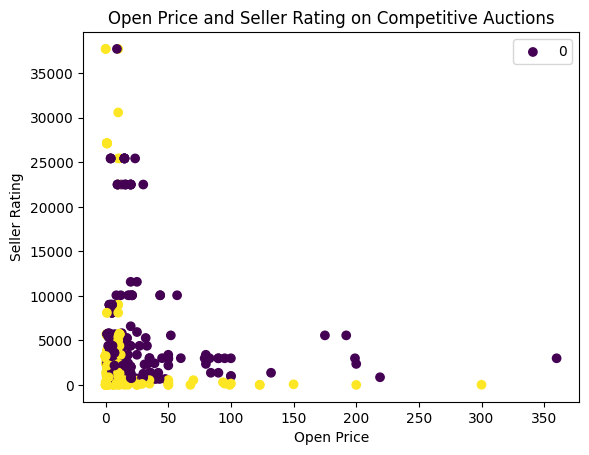

In [121]:
# e Plot the resulting tree on a scatter plot
#plt.scatter(X_2, y_2)
preds = fullClassTree_2.predict(valid_X_2)
plt.scatter(valid_X_2['OpenPrice'], valid_X_2['sellerRating'], c=preds)
plt.xlabel("Open Price")
plt.ylabel("Seller Rating")
plt.legend(preds)

plt.title("Open Price and Seller Rating on Competitive Auctions")

# len(X_2) == len(y_2)
# Is splitting reasonable?

Confusion Matrix (Accuracy 0.7148)

       Prediction
Actual   0   1
     0 222 131
     1  94 342


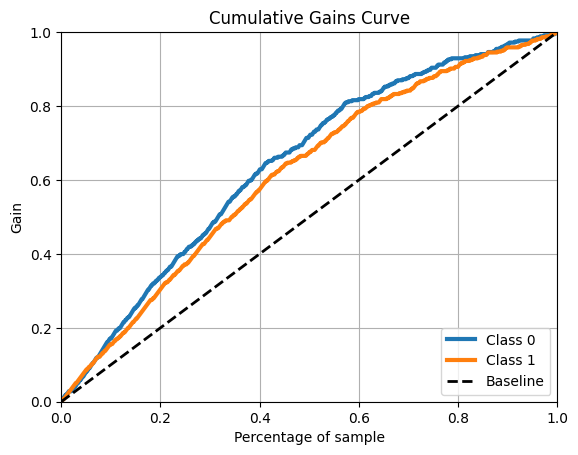

In [75]:
# f lift chart and the confusion matrix
classificationSummary(valid_y_2, fullClassTree_2.predict(valid_X_2))
preds = fullClassTree_2.predict_proba(valid_X_2)

skplt.metrics.plot_cumulative_gain(valid_y_2, preds)
plt.show()

# g. Based on this last tree, what can you conclude from these data about the chances of an auction obtaining at least two bids and its  relationship to the auction settings set by the seller (duration, opening price, ending day, currency)? What would you recommend for a seller as the strategy that will most likely lead to a competitive auction?

For sellers with both a high rating and a low rating, the best strategy for a competitive auction is to have a lower OpenPrice. Starting with a higher OpenPrice, though possible for highly rated sellers, tends to result in an auction with one bid.

# Problem 9.3

Predicting Prices of Used Cars (Regression Trees). 

The file ToyotaCorolla.csv contains the data on used cars (Toyota Corolla) on sale during late summer of 2004 in the Netherlands. It has 1436 records containing details on 38 attributes, including Price, Age, Kilometers, HP, and other specifications. The goal is to predict the price
of a used Toyota Corolla based on its specifications. (The example in Section 9.7 is a subset of this dataset.) 

Data Preprocessing. Split the data into training (60%), and validation (40%) datasets.

a. Run a full-grown regression tree (RT) with outcome variable Price and predictors Age_08_04, KM, Fuel_Type (first convert to dummies), HP, Automatic, Doors, Quarterly_Tax, Mfr_Guarantee, Guarantee_Period, Airco, Automatic_airco, CD_Player, Powered_Windows, Sport_Model, and Tow_Bar. Set random_state=1.
    i. Which appear to be the three or four most important car specifications for predicting the car’s price?
    ii. Compare the prediction errors of the training and validation sets by examining their RMS error and by plotting the two boxplots. How does the predictive performance of the validation set compare to the training set? Why does this occur?
    iii. How might we achieve better validation predictive performance at the expense of training performance?
    iv. Create a smaller tree by using GridSearchCV() with cv = 5 to find a fine-tuned tree. Compared to the full-grown tree, what is the predictive performance on the validation set?
b. Let us see the effect of turning the price variable into a categorical variable. First, create a new variable that categorizes price into 20 bins. Now repartition the data keeping Binned_Price instead of Price. Run a classification tree with the same set of input variables as in the RT, and with Binned_Price as the output variable. As in the less deep regression tree, create a smaller tree by using GridSearchCV() with
cv = 5 to find a fine-tuned tree.
    i. Compare the smaller tree generated by the CT with the smaller tree generated by RT. Are they different? (Look at structure, the top predictors, size of tree, etc.) Why?
    ii. Predict the price, using the smaller RT and CT, of a used Toyota Corolla with the specifications listed in Table 9.10.

        TABLE 9.10 SPECIFICATIONS FOR A PARTICULAR TOYOTA COROLLA
        Variable            Value
        Age_-08_-04         77
        KM                  117,000
        Fuel_Type           Petrol
        HP                  110
        Automatic           No
        Doors               5
        Quarterly_Tax       100
        Mfg_Guarantee       No
        Guarantee_Period    3
        Airco               Yes
        Automatic_airco     No
        CD_Player           No
        Powered_Windows     No
        Sport_Model         No
        Tow_Bar             Yes

    iii. Compare the predictions in terms of the predictors that were used, the magnitude of the difference between the two predictions, and the advantages and disadvantages of the two methods.

In [16]:
# Pre-processing
toyotaCorolla_df = pd.read_csv('ToyotaCorolla.csv')

toyotaCorolla_df = toyotaCorolla_df.rename(columns={'Age_08_04': 'Age', 'Quarterly_Tax': 'Tax'})

predictors = ['Age', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 'Doors', 'Tax', 'Weight']
outcome = 'Price'

X = pd.get_dummies(toyotaCorolla_df[predictors], drop_first=True)
y = toyotaCorolla_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [7]:
# a

# create a regressor object
regTree = DecisionTreeRegressor(random_state = 1) 
  
# fit the regressor with X and Y data
regTree.fit(train_X, train_y)


DecisionTreeRegressor(random_state=1)

# i. Which appear to be the three or four most important car specifications for predicting the car’s price?
   
Age             8.41058553e-01 
KM              5.89986658e-02
HP              5.55734179e-02
Met_Color       3.07059056e-03
Automatic       1.27158901e-03
CC              2.03786985e-03
Doors           4.24503831e-03
Tax             3.26629363e-03
Weight          3.03948295e-02 
Diesel Fuel     7.92420617e-05 
Petrol Fuel     3.91028035e-06


In [8]:
feat_importance = regTree.tree_.compute_feature_importances(normalize=True)
print("feat importance = " + str(feat_importance))

tree_rules_2 = export_text(regTree, feature_names=list(train_X.columns))
print(tree_rules_2)

print(X.columns)


feat importance = [8.41058553e-01 5.89986658e-02 5.55734179e-02 3.07059056e-03
 1.27158901e-03 2.03786985e-03 4.24503831e-03 3.26629363e-03
 3.03948295e-02 7.92420617e-05 3.91028035e-06]
|--- Age <= 32.50
|   |--- HP <= 113.00
|   |   |--- Age <= 21.00
|   |   |   |--- Weight <= 1127.50
|   |   |   |   |--- KM <= 24172.50
|   |   |   |   |   |--- KM <= 12828.50
|   |   |   |   |   |   |--- KM <= 113.00
|   |   |   |   |   |   |   |--- Doors <= 4.50
|   |   |   |   |   |   |   |   |--- CC <= 1500.00
|   |   |   |   |   |   |   |   |   |--- value: [17795.00]
|   |   |   |   |   |   |   |   |--- CC >  1500.00
|   |   |   |   |   |   |   |   |   |--- value: [17900.00]
|   |   |   |   |   |   |   |--- Doors >  4.50
|   |   |   |   |   |   |   |   |--- value: [18245.00]
|   |   |   |   |   |   |--- KM >  113.00
|   |   |   |   |   |   |   |--- KM <= 3190.00
|   |   |   |   |   |   |   |   |--- value: [21125.00]
|   |   |   |   |   |   |   |--- KM >  3190.00
|   |   |   |   |   |   |   |   |-

# ii. Compare the prediction errors of the training and validation sets by examining their RMS error and by plotting the two boxplots. How does the predictive performance of the validation set compare to the training set? Why does this occur?

In [12]:
regressionSummary(train_y, regTree.predict(train_X))
regressionSummary(valid_y, regTree.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1101.0597
            Mean Absolute Error (MAE) : 800.4555
          Mean Percentage Error (MPE) : -1.0396
Mean Absolute Percentage Error (MAPE) : 7.8185

Regression statistics

                      Mean Error (ME) : 4.9461
       Root Mean Squared Error (RMSE) : 1230.7881
            Mean Absolute Error (MAE) : 943.1207
          Mean Percentage Error (MPE) : -1.2718
Mean Absolute Percentage Error (MAPE) : 9.4966


# iii. How might we achieve better validation predictive performance at the expense of training performance?
We could obtain better validation predictive performance by making the training set smaller. In this way, we can avoid overtraining and overfitting on the data.


# iv. Create a smaller tree by using GridSearchCV() with cv = 5 to find a fine-tuned tree. Compared to the full-grown tree, what is the predictive performance on the validation set?

In [10]:
# user grid search to find optimized tree
param_grid = {
'max_depth': [5, 10, 15, 20, 25],
'min_impurity_decrease': [0, 0.001, 0.005, 0.01],
'min_samples_split': [10, 20, 30, 40, 50],
}

gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)

print('Initial parameters: ', gridSearch.best_params_)

param_grid = {
'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008],
'min_samples_split': [14, 15, 16, 18, 20, ],
}

gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)

print('Improved parameters: ', gridSearch.best_params_)
regTree = gridSearch.best_estimator_

regressionSummary(train_y, regTree.predict(train_X))
regressionSummary(valid_y, regTree.predict(valid_X))

Initial parameters:  {'max_depth': 5, 'min_impurity_decrease': 0.001, 'min_samples_split': 10}
Improved parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 14}

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1101.0597
            Mean Absolute Error (MAE) : 800.4555
          Mean Percentage Error (MPE) : -1.0396
Mean Absolute Percentage Error (MAPE) : 7.8185

Regression statistics

                      Mean Error (ME) : 4.9461
       Root Mean Squared Error (RMSE) : 1230.7881
            Mean Absolute Error (MAE) : 943.1207
          Mean Percentage Error (MPE) : -1.2718
Mean Absolute Percentage Error (MAPE) : 9.4966


In [17]:
tmp_df = toyotaCorolla_df

toyota_b = toyotaCorolla_df
toyota_b['Price'] = pd.cut(tmp_df.Price, bins=20, labels=False, include_lowest=True)

predictors = ['Age', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 'Doors', 'Tax', 'Weight']
outcome = 'Price'

X = pd.get_dummies(toyota_b[predictors], drop_first=True)
y = toyota_b[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [18]:
# create a regressor object
regTree_2 = DecisionTreeRegressor(random_state = 1) 
  
# fit the regressor with X and Y data
regTree_2.fit(train_X, train_y)

regressionSummary(train_y, regTree_2.predict(train_X))
regressionSummary(valid_y, regTree_2.predict(valid_X))

tree_rules = export_text(regTree_2, feature_names=list(train_X.columns))
print(tree_rules)


Regression statistics

               Mean Error (ME) : 0.0000
Root Mean Squared Error (RMSE) : 0.0000
     Mean Absolute Error (MAE) : 0.0000

Regression statistics

               Mean Error (ME) : 0.0052
Root Mean Squared Error (RMSE) : 1.1041
     Mean Absolute Error (MAE) : 0.7774
|--- Age <= 32.50
|   |--- HP <= 113.00
|   |   |--- Age <= 21.00
|   |   |   |--- Weight <= 1127.50
|   |   |   |   |--- KM <= 24172.50
|   |   |   |   |   |--- Weight <= 1102.50
|   |   |   |   |   |   |--- HP <= 97.50
|   |   |   |   |   |   |   |--- value: [8.00]
|   |   |   |   |   |   |--- HP >  97.50
|   |   |   |   |   |   |   |--- Age <= 11.50
|   |   |   |   |   |   |   |   |--- value: [9.00]
|   |   |   |   |   |   |   |--- Age >  11.50
|   |   |   |   |   |   |   |   |--- value: [10.00]
|   |   |   |   |   |--- Weight >  1102.50
|   |   |   |   |   |   |--- KM <= 16711.50
|   |   |   |   |   |   |   |--- Age <= 4.50
|   |   |   |   |   |   |   |   |--- value: [11.00]
|   |   |   |   |   |   

In [19]:
# user grid search to find optimized tree
param_grid = {
'max_depth': [5, 10, 15, 20, 25],
'min_impurity_decrease': [0, 0.001, 0.005, 0.01],
'min_samples_split': [10, 20, 30, 40, 50],
}

gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)

print('Initial parameters: ', gridSearch.best_params_)

param_grid = {
'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008],
'min_samples_split': [14, 15, 16, 18, 20, ],
}

gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)

print('Improved parameters: ', gridSearch.best_params_)
regTree = gridSearch.best_estimator_

regressionSummary(train_y, regTree.predict(train_X))
regressionSummary(valid_y, regTree.predict(valid_X))

tree_rules = export_text(regTree, feature_names=list(train_X.columns))
print(tree_rules)

Initial parameters:  {'max_depth': 5, 'min_impurity_decrease': 0.001, 'min_samples_split': 10}
Improved parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.007, 'min_samples_split': 14}

Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 0.7722
     Mean Absolute Error (MAE) : 0.6005

Regression statistics

               Mean Error (ME) : 0.0318
Root Mean Squared Error (RMSE) : 0.9191
     Mean Absolute Error (MAE) : 0.7104
|--- Age <= 32.50
|   |--- HP <= 113.00
|   |   |--- Age <= 21.00
|   |   |   |--- Weight <= 1127.50
|   |   |   |   |--- KM <= 24172.50
|   |   |   |   |   |--- value: [9.58]
|   |   |   |   |--- KM >  24172.50
|   |   |   |   |   |--- value: [8.00]
|   |   |   |--- Weight >  1127.50
|   |   |   |   |--- Age <= 13.50
|   |   |   |   |   |--- value: [12.25]
|   |   |   |   |--- Age >  13.50
|   |   |   |   |   |--- value: [10.43]
|   |   |--- Age >  21.00
|   |   |   |--- Weight <= 1175.00
|   |   |   |   |--- HP 

In [22]:
# i
# RT
feat_importance = regTree_2.tree_.compute_feature_importances(normalize=True)
print ("feat importance = " + str(feat_importance))
      
# GridSearchCV
feat_importance = regTree.tree_.compute_feature_importances(normalize=True)
print ("feat importance = " + str(feat_importance))

print(X.columns)

feat importance = [8.34116999e-01 6.49751986e-02 4.89798659e-02 4.35859661e-03
 9.71243610e-04 1.66871248e-03 3.21335501e-03 1.23398252e-02
 2.86637608e-02 5.42556408e-04 1.69886849e-04]
feat importance = [0.89325319 0.03900886 0.05005252 0.         0.         0.
 0.         0.         0.01768544 0.         0.        ]
Index(['Age', 'KM', 'HP', 'Met_Color', 'Automatic', 'CC', 'Doors', 'Tax',
       'Weight', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol'],
      dtype='object')


# Top Predictors
Full-tree:          GridSearchCV:
Age                 Age
KM                  HP
HP                  KM
Weight              Weight

# Structure
Rather than being a tree that is heavily leaned, using bins leads to a tree that appears relatively balanced.

# Size
Using bins leads to a tree that is significantly smaller.

# Explain why 
Using bins reduces the number of variables. Since price is now sorted into a finite number of categorical bins rather than a continuous value, the number of variables can be greatly reduced to fit the outcome prediction.

In [37]:
# ii. Predict the price, using the smaller RT and CT, of a used Toyota Corolla with the specifications listed in Table 9.10.
sample_car = pd.DataFrame(columns=X.columns)
# sample_car.loc[0] = [77, 117000, 'Petrol', 110, 'No', 5, 100, 'No', 3, 'Yes', 'No' 'No', 'No', 'No', 'Yes']
sample_car.loc[0] = [77, 117000, 110, 0, 0, 1, 5, 100, 50, 0, 1]

fullClassTree = DecisionTreeClassifier(random_state=1, min_samples_leaf=50, max_depth=7)
fullClassTree.fit(train_X, train_y)

RT_pred = regTree.predict(sample_car)
CT_pred = fullClassTree.predict(sample_car)

print(RT_pred)
print(CT_pred)

tmp_df = toyotaCorolla_df
print(pd.cut(tmp_df.Price, bins=20, retbins=True))


[1.60344828]
[1]
(0       (5.7, 6.65]
1       (5.7, 6.65]
2       (5.7, 6.65]
3       (6.65, 7.6]
4       (5.7, 6.65]
           ...     
1431    (1.9, 2.85]
1432    (3.8, 4.75]
1433    (1.9, 2.85]
1434    (1.9, 2.85]
1435    (0.95, 1.9]
Name: Price, Length: 1436, dtype: category
Categories (20, interval[float64, right]): [(-0.019, 0.95] < (0.95, 1.9] < (1.9, 2.85] < (2.85, 3.8] ... (15.2, 16.15] < (16.15, 17.1] < (17.1, 18.05] < (18.05, 19.0]], array([-0.019,  0.95 ,  1.9  ,  2.85 ,  3.8  ,  4.75 ,  5.7  ,  6.65 ,
        7.6  ,  8.55 ,  9.5  , 10.45 , 11.4  , 12.35 , 13.3  , 14.25 ,
       15.2  , 16.15 , 17.1  , 18.05 , 19.   ]))


# iii Compare the predictions in terms of the predictors that were used, the magnitude of the difference between the two predictions, and the advantages and disadvantages of the two methods.

Regression Tree with bins: $9,120
Classification Tree with bins: $6,650

In this instance, the Regression Tree performed better since it was better trained. Our regression model made use of GridSearchCV to find parameters that functioned well for this given set. This is opposed to the Classification Tree, which did not have any additional tuning.

Each tree functions in different ways, and the application and underlying data will determine which tree is best for which situation.
